# Jonathan Halverson
# Friday, January 19, 2018
# Write like Melville: Complete the next word

Here we train an RNN to predict the last word of a sentence. The model is trained on sentences written by Herman Melville. We could have also broken the sentences into phrases.

In [1]:
import nltk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
import re
from collections import Counter

### Load the books

In [3]:
melville_raw = list(nltk.corpus.gutenberg.words('melville-moby_dick.txt'))
melville = melville_raw[melville_raw.index('Loomings'):]

In [4]:
with open('melville_pierre.txt') as f:
     melville2 = f.read().decode('utf-8').encode('ascii', 'ignore').replace('\n', ' ').split()

In [5]:
def make_sentences(x):
     j = ' '.join(x).replace('Mr .', 'Mr').replace('Mrs .', 'Mrs')
     j = j.replace('Ms .', 'Ms').replace('Dr .', 'Dr').replace('\n', ' ')
     j = j.replace('?', '.').replace('!', '.').replace('CHAPTER', ' ')
     sentences = j.split('.')
     s = [re.sub("[^a-zA-Z]", " ", sentence) for sentence in sentences]
     s = [sentence.lower().split() for sentence in s]
     return s

In [6]:
def remove_single_letters_except_ia(sentences):
     new_sentences = []
     for sentence in sentences:
          cleaned_sentence = []
          for word in sentence:
               if len(word) > 1:
                    cleaned_sentence.append(word)
               else:
                    if word in ['a', 'i']:
                         cleaned_sentence.append(word)
          new_sentences.append(cleaned_sentence)
     return new_sentences

In [7]:
def remove_short_and_long_sentences(sentences, low, high):
     new_sentences = []
     for sentence in sentences:
          if (len(sentence) >= low and len(sentence) <= high):
               new_sentences.append(sentence)
     return new_sentences

In [8]:
def replace_word_with_index_and_zero_pad(sentences, dictionary, high):
     number_sentences = []
     target_sentences = []
     for sentence in sentences:
          number_sentence = [dictionary[word] for word in sentence[:-1]]
          target_sentence = dictionary[sentence[-1]]
          for _ in range(high - len(number_sentence) - 1):
               number_sentence.append(0)
          number_sentences.append(number_sentence)
          target_sentences.append(target_sentence)
     return np.array(number_sentences), np.array(target_sentences).astype(np.int32)

In [9]:
def testing__replace_word_with_index_and_zero_pad(sentences, dictionary, high):
     number_sentences = []
     for sentence in sentences:
          number_sentence = [dictionary[word] for word in sentence]
          for _ in range(high - len(number_sentence) - 1):
               number_sentence.append(0)
          number_sentences.append(number_sentence)
     return np.array(number_sentences)

In [10]:
s1 = remove_single_letters_except_ia(make_sentences(melville))
#+ remove_single_letters_except_ia(make_sentences(melville2))

In [11]:
upper_bound = 20
s1 = remove_short_and_long_sentences(s1, 5, upper_bound)

In [12]:
print len(s1)

4041


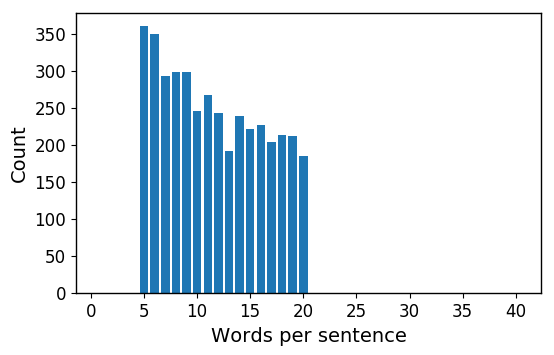

In [13]:
plt.hist([len(s) for s in s1], bins=np.linspace(0.5, 40.5, 41), rwidth=0.8)
plt.xlabel('Words per sentence')
plt.ylabel('Count')

In [14]:
all_words = [word for sentence in s1 for word in sentence]

In [15]:
len(all_words)

47053

In [16]:
unique_words = set(all_words)
vocabulary_size = len(unique_words)
vocabulary_size

7220

In [17]:
dictionary = dict([(word, index) for index, word in enumerate(unique_words)])
inverse_dictionary = dict([(index, word) for index, word in enumerate(unique_words)])

In [18]:
dictionary['whale']

7108

In [19]:
inverse_dictionary[7108]

u'whale'

In [20]:
all_sentences, target = replace_word_with_index_and_zero_pad(s1, dictionary, high=upper_bound)

In [21]:
all_sentences[0]

array([3926, 3925, 2837, 2216, 3470, 5205, 6295, 5612, 1722, 2140, 3363,
       6119, 1258, 2140,    0,    0,    0,    0,    0])

In [22]:
target[0]

2699

In [23]:
' '.join([inverse_dictionary[code] for code in all_sentences[0]])

u'it is a way i have of driving off the spleen and regulating the cussed cussed cussed cussed cussed'

In [24]:
inverse_dictionary[target[0]]

u'circulation'

In [25]:
seq_length = np.array([len(sentence) for sentence in s1]) - 1

In [26]:
idx = np.arange(target.shape[0])
np.random.shuffle(idx)
X_training = all_sentences[idx]
y_training = target[idx]
L_training = seq_length[idx]

In [27]:
def fetch_batch(A, b, c, batch_size):
     idx = np.random.choice(np.arange(y_training.size), size=batch_size, replace=False)
     return A[idx], b[idx], c[idx]

In [28]:
tf.reset_default_graph()

In [29]:
embedding_size = 32
n_inputs = embedding_size
n_steps = 19
n_neurons = 64

In [30]:
X = tf.placeholder(tf.int32, shape=(None, n_steps))
y = tf.placeholder(tf.int32, shape=(None))
L = tf.placeholder(dtype=tf.int32, shape=(None))
training = tf.placeholder_with_default(False, shape=(None))

In [31]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), trainable=True)
embed = tf.nn.embedding_lookup(params=embeddings, ids=X)

In [32]:
cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(cell, embed, dtype=tf.float32, sequence_length=L)
fc_drop = tf.layers.dropout(states, rate=0.5, training=training)
logits = tf.layers.dense(fc_drop, units=vocabulary_size, activation=None)
p = tf.nn.softmax(logits, dim=1)
predicted_index = tf.cast(tf.argmax(logits, axis=1), tf.int32)

In [33]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

In [34]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(loss)

In [35]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(y, predicted_index), tf.float32))

In [36]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
batch_size = 75
epochs = 100

In [38]:
ckpt_name = 'my_melville_rnn.ckpt'
with tf.Session() as sess:
     init.run()
     for epoch in xrange(epochs + 1):
          for iteration in xrange(y_training.size // batch_size):
               X_batch, y_batch, L_batch = fetch_batch(X_training, y_training, L_training, batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch, L:L_batch, training:True})
          acc, lss = sess.run([accuracy, loss], feed_dict={X:X_batch, y:y_batch, L:L_batch})
          if epoch % 10 == 0: print epoch, acc, lss
     save_path = saver.save(sess, ckpt_name)

0 0.0533333 7.41485
10 0.906667 0.689569
20 0.973333 0.103143
30 1.0 0.015105
40 1.0 0.00952502
50 1.0 0.0075203
60 1.0 0.00228968
70 1.0 0.00111354
80 1.0 0.00164627
90 0.973333 0.0892439
100 1.0 0.000700741


In [42]:
with tf.Session() as sess:
     saver.restore(sess, ckpt_name)
     sentences = [['the', 'winter', 'was', 'not'], ['it', 'was', 'a'], ['i', 'felt'], ['the', 'whale', 'had']]
     X_new = testing__replace_word_with_index_and_zero_pad(sentences, dictionary, high=upper_bound)
     L_new = [len(sentence) for sentence in sentences]
     idx = predicted_index.eval(feed_dict={X:X_new, L:L_new})
     prob = p.eval(feed_dict={X:X_new, L:L_new})

INFO:tensorflow:Restoring parameters from my_melville_rnn.ckpt


In [43]:
for i, sentence in enumerate(sentences):
     print ' '.join(sentence), inverse_dictionary[idx[i]], prob.max(axis=1)[i]

the winter was not thirty 0.266092
it was a dish 0.108557
i felt thee 0.782056
the whale had there 0.287393


In [44]:
prob.sum(axis=1)

array([ 1.00001287,  1.00000012,  1.00000191,  0.99999952], dtype=float32)

It's odd that we train on long sentences and then feed in short ones. One could try generating the next word multiple times by using recursion.